In [1]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import time

# Classification models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Preprocessing
import nltk
import re

# Download nltk resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Exploração do Dataset

In [2]:
path = "../data/binary/"
df = pd.read_csv(path + 'WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
print(df.info())
print(df['label'].value_counts())
df.dropna(subset=['text'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
label
1    37106
0    35028
Name: count, dtype: int64


## Preprocessamento do Dataset

In [4]:
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)
    
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,comment expected barack obama member fyf911 fu...,1
1,1,NaN,post vote hillary already,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,demonstrator gathered last night exercising co...,1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",dozen politically active pastor came private d...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,rs28 sarmat missile dubbed satan 2 replace ss1...,1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,washington reuters hacker believed working rus...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,know fantasyland republican never questioned c...,1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,migrant refuse leave train refugee camp hungar...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,mexico city reuters donald trump combative sty...,0


In [5]:
df.dropna(inplace=True)
df = df.groupby('label').apply(lambda x: x.sample(frac=0.2)).reset_index(drop=True)
df['label'].value_counts()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_24848\2107073711.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(frac=0.05)).reset_index(drop=True)


label
1    1825
0    1751
Name: count, dtype: int64

## Divisão do Dataset em treino e teste

In [6]:
features = df['text']
target = df['label']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=421)

## Definição dos vetorizadores, modelos e parâmetros para o GridSearch

In [7]:
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer()
]

param_grids = [
    {
        'vectorizer': vectorizers,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [SVC()],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 1.0]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [1, 10],
    },
    {
        'vectorizer': vectorizers,
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 150]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [SGDClassifier()],
        'classifier__alpha': [0.0001, 0.001]
    }
]

pipeline = Pipeline([
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

## Execução do GridSearch

In [8]:
grid_search = GridSearchCV(pipeline, param_grids, cv=5, n_jobs=7, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 74 candidates, totalling 370 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=7,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [None, 10, 20],
                          'classifier__n_estimators': [100, 150, 200],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [SVC()], 'classifier__C': [1, 10],
                          'classifi...
                          'classifier__n_estimators': [100, 150, 200],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [AdaBoostClassifier()],
                          'classifier__n_estimators': [50, 100, 150],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [SGDClassifier()],
                          'classifier__alpha': [0.0001, 0.001],
                          'vectorizer': [TfidfVectorizer(),
                                         CountVectorizer()]}],
             scoring='accuracy', verbose=2)

## Resultados finais e matriz de confusão

In [9]:
cv_results = grid_search.cv_results_

results_df = pd.DataFrame(cv_results)

results_df.to_csv('results/sklearn_binary2_results.csv', sep=';', index=False)

In [10]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest set classification report with best model:")
print(classification_report(y_test, y_pred, digits=4))

Best parameters found: {'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'vectorizer': TfidfVectorizer()}
Best cross-validation score: 0.9248251748251748

Test set classification report with best model:
              precision    recall  f1-score   support

           0     0.9590    0.8994    0.9282       338
           1     0.9148    0.9656    0.9395       378

    accuracy                         0.9344       716
   macro avg     0.9369    0.9325    0.9339       716
weighted avg     0.9357    0.9344    0.9342       716



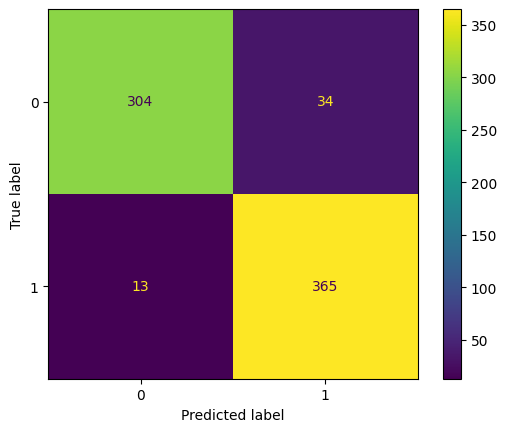

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis')

In [12]:
import pickle
# Save the model with pickle
filename = 'models/sklearn_binary2_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)